In [1]:
import pickle

with open('./dataset complete/train_test_data/train_data.pkl', 'rb') as file:
    train_data = pickle.load(file)
train_inputs, train_contexts = train_data[0]
train_tagets = train_data[1]
del train_data

In [2]:
with open('./dataset complete/train_test_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)
test_inputs, test_contexts = test_data[0]
test_tagets = test_data[1]
del test_data

In [3]:
import json

with open ("./dataset complete/character_to_prediction_index.json", "r") as f:
    characters = json.load(f)

# TODO: tune hyperparameters
EPOCHS = 20
BATCH_SIZE=64
d_model = 128  # hidden layer(s) dimensionality
num_layers = 4 # how many encoders and decoders to stack
num_heads = 7 # how many attention heads should every mha have
ff_dim = 200 # how many neurons shall feed-forward layers have
dropout_rate = 0.1

output_vocab_size = len(characters) + 2

In [4]:
from transformer import get_compiled_transformer

transformer = get_compiled_transformer(
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout_rate=dropout_rate,
    output_vocab_size=output_vocab_size
)

In [5]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoints/cp-{epoch:04d}.ckpt", save_weights_only=True, verbose=1
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = transformer.fit([train_inputs[:100], train_contexts[:100]], train_tagets[:100], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[cp_callback, es_callback])

transformer.evaluate([test_inputs[:100], test_contexts[:100]], test_tagets[:100], batch_size=BATCH_SIZE)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'transformer/encoder/encoder_layer_2/global_self_attention_2/multi_head_attention_2/einsum/Einsum' defined at (most recent call last):
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\IPython\core\interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\IPython\core\interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\IPython\core\interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\IPython\core\interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\WG\AppData\Local\Temp\ipykernel_9852\1805447703.py", line 10, in <module>
      history = transformer.fit([train_inputs[:100], train_contexts[:100]], train_tagets[:100], epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[cp_callback, es_callback])
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\Documents\PML Projekt\transformer.py", line 231, in call
      x_enc = self.encoder(mp_data)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\Documents\PML Projekt\transformer.py", line 160, in call
      for i in range(self.num_layers):
    File "C:\Users\WG\Documents\PML Projekt\transformer.py", line 161, in call
      x = self.enc_layers[i](x)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\Documents\PML Projekt\transformer.py", line 130, in call
      x = self.self_attention(x)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\Documents\PML Projekt\transformer.py", line 78, in call
      attn_output = self.mha(
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 596, in call
      attention_output, attention_scores = self._compute_attention(
    File "C:\Users\WG\miniconda3\envs\PML_Projekt\lib\site-packages\keras\layers\attention\multi_head_attention.py", line 525, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key, query)
Node: 'transformer/encoder/encoder_layer_2/global_self_attention_2/multi_head_attention_2/einsum/Einsum'
OOM when allocating tensor with shape[64,7,900,900] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transformer/encoder/encoder_layer_2/global_self_attention_2/multi_head_attention_2/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13427]

In [ ]:
print(history.history.keys())

In [1]:
import matplotlib.pyplot as plt

plt.plot(history.history['masked_accuracy'])
plt.plot(history.history['val_masked_accuracy'])
plt.title('Accuracy over Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

ImportError: DLL load failed while importing _imaging: Das angegebene Modul wurde nicht gefunden.

In [2]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'plt' is not defined

# Data Generator

In [1]:
import os
import pandas as pd
from copy import deepcopy
import numpy as np
import random
from tensorflow import keras

class ASLDataGenerator(keras.utils.Sequence):

    def __init__(self, dataset_path: str, max_phrase_length: int, max_sign_length: int, batch_size: int, train: bool = True):
        super().__init__()
        self.ds_path = dataset_path
        self.files = os.listdir(dataset_path)
        self.max_phrase_length = max_phrase_length
        self.max_sign_length = max_sign_length
        self.unwanted_columns = ['sequence_id', 'frame', 'participant_id', 'phrase']
        self.train = train
        self.batch_size = batch_size

    def __len__(self):
        return len(self.files)//self.batch_size

    def shuffle(self):
        random.shuffle(self.files)

    def on_epoch_end(self):
        if self.train:
            self.shuffle()

    def __getitem__(self, idx: int):
        # TODO: integrate batch_size --> take all examples from idx to idx + batch_size
        batch_signs = []
        batch_contexts = []
        batch_phrases = []
        for i in range(idx, idx+self.batch_size):
            df_phrase = pd.read_pickle(self.ds_path + '/' + self.files[idx])
            phrase = df_phrase.iloc[0].phrase
            if len(phrase) > self.max_phrase_length:
                print('Houston we have a problem!')

            while len(phrase) < self.max_phrase_length:
                phrase.append(59)
            context = deepcopy(phrase)
            context.insert(0, 60)
            context = context[:-1]

            df_phrase = df_phrase.drop(self.unwanted_columns, axis=1)
            signs = df_phrase.to_numpy(copy=True)

            if signs.shape[0] > self.max_sign_length:
                print('Hooooouuuuusteeeeeen!')
            signs = np.pad(signs, [(0, self.max_sign_length-signs.shape[0]), (0,0)], 'edge')
            batch_signs.append(signs)
            batch_contexts.append(context)
            batch_phrases.append(phrase)

        batch_signs = np.array(batch_signs)
        batch_contexts = np.array(batch_contexts)
        batch_phrases = np.array(batch_phrases)

        return [batch_signs, batch_contexts], batch_phrases

In [2]:
from tensorflow import keras

class ShuffleCallback(keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        data_gen_train.shuffle()

In [3]:
import tensorflow as tf
MAX_PHRASE_LENGTH = 100
MAX_SIGN_LENGTH = 900
BATCH_SIZE=32

data_gen_train = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/train_files', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, batch_size=BATCH_SIZE)
data_gen_train.shuffle()

data_gen_test = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/test_files', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, train=False, batch_size=BATCH_SIZE)

data_gen_val = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/validation_files', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, train=False, batch_size=BATCH_SIZE)

In [17]:
input, phrase = data_gen_train[0]

# Train Transformer using Generator

In [20]:
import json

with open ("./dataset complete/character_to_prediction_index.json", "r") as f:
    characters = json.load(f)

# TODO: tune hyperparameters
EPOCHS = 20
d_model = 200  # hidden layer(s) dimensionality
num_layers = 6 # how many encoders and decoders to stack
num_heads = 4 # how many attention heads should every mha have
ff_dim = 300 # how many neurons shall feed-forward layers have
dropout_rate = 0.2

output_vocab_size = len(characters) + 1

In [21]:
from transformer import get_compiled_transformer

transformer = get_compiled_transformer(
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout_rate=dropout_rate,
    output_vocab_size=output_vocab_size
)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoints/cp-{epoch:04d}.ckpt", save_weights_only=True, verbose=1
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
shuffle_callback = ShuffleCallback()

history = transformer.fit(data_gen_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=data_gen_val, callbacks=[cp_callback, es_callback])

transformer.evaluate(data_gen_test, batch_size=BATCH_SIZE)

Epoch 1/20
1188/1188 [==============================] - ETA: 0s - loss: 3.2746 - masked_accuracy: 0.1039
Epoch 1: saving model to model_checkpoints\cp-0001.ckpt
1188/1188 [==============================] - 969s 809ms/step - loss: 3.2746 - masked_accuracy: 0.1039 - val_loss: 2.9323 - val_masked_accuracy: 0.1495
Epoch 2/20
  83/1188 [=>............................] - ETA: 14:10 - loss: 2.9173 - masked_accuracy: 0.1443

In [19]:
print(history.history.keys())

dict_keys(['loss', 'masked_accuracy', 'val_loss', 'val_masked_accuracy'])


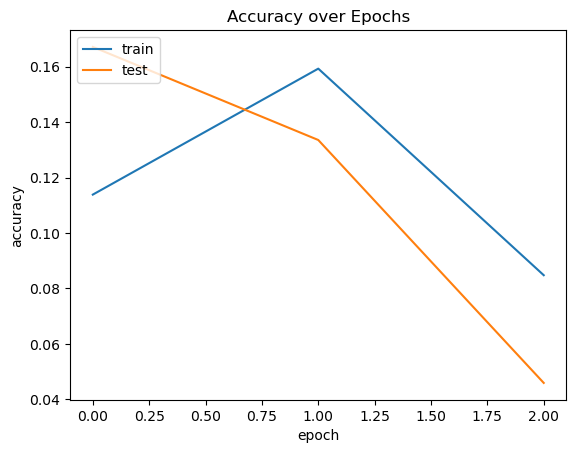

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['masked_accuracy'])
plt.plot(history.history['val_masked_accuracy'])
plt.title('Accuracy over Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

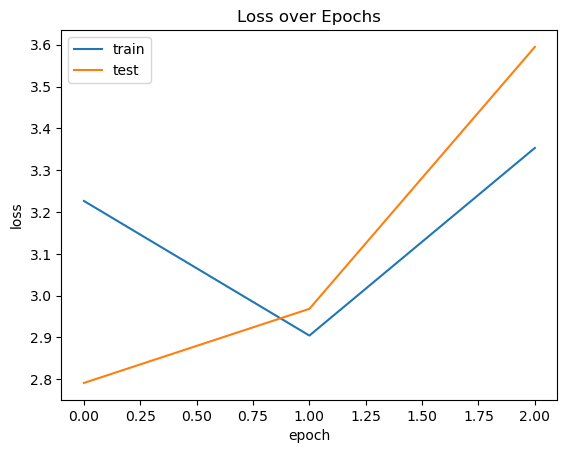

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()